# Analyzing the India Covid-19 stats

## This notebook is highly motivated by https://github.com/k-sys/covid-19

Given the current focus on Covid-19, lets try and do some basic data analysis with whatever data is publicly available. As of now this notebook is India specific but of course the analysis techniques are applicable to any country, state, or geographic area as long as the data is suitably available.

In [203]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output


## Read the csv file from an URL
Lets first get the data. The data from the https://www.covid19india.org/ project is available at https://api.covid19india.org/ and for the most part we will use the CSV files only. Kudos to this volunteer team that has done a wonderful job of verifying and then analysing the crowdsourced data of country wide Covid-19 related reports and statistics. 

In [212]:
# if you have downloaded the file already
# filename = "confirmed.csv"

# but it is more convenient if you can download it right now!
filename = "http://api.covid19india.org/states_daily_csv/confirmed.csv"
data = pd.read_csv(filename) # from now on 'data' is god!

# Some global variables
# title fonts
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 20,
        }

# axis font
myfontsize=16

# standard deviation for gaussian distribution
std_dev=2

# days to use as window for rolling calculations
window=5


## Warmup, try to get a plot of daily counts of some specific states and the country total.
This is just to get warmed up and really does not involve any analysis but just plots the data so that it can be visualized and hence better understood.

Index(['date', 'TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DD', 'DL',
       'DN', 'GA', 'GJ', 'HP', 'HR', 'JH', 'JK', 'KA', 'KL', 'LA', 'LD', 'MH',
       'ML', 'MN', 'MP', 'MZ', 'NL', 'OR', 'PB', 'PY', 'RJ', 'SK', 'TG', 'TN',
       'TR', 'UP', 'UT', 'WB', 'Unnamed: 39'],
      dtype='object')


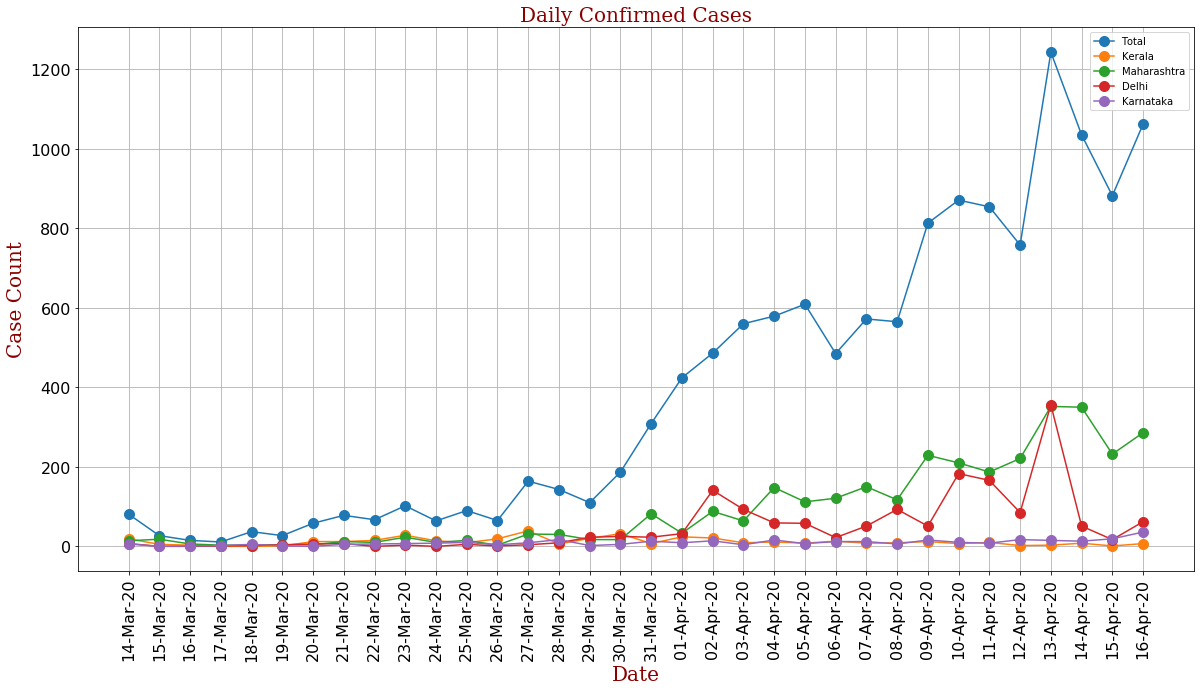

In [213]:
confirmed = data
print(confirmed.columns)
#print(confirmed.describe())


# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['date'], axis=1)

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)

plt.title('Daily Confirmed Cases', fontdict=font)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Case Count', fontdict=font)

plt.plot(dates, confirmed['TT'], marker='o', markersize=10)
plt.plot(dates, confirmed['KL'], marker='o', markersize=10)
plt.plot(dates, confirmed['MH'], marker='o', markersize=10)
plt.plot(dates, confirmed['DL'], marker='o', markersize=10)
plt.plot(dates, confirmed['KA'], marker='o', markersize=10)
plt.legend(['Total', 'Kerala', 'Maharashtra', 'Delhi', 'Karnataka'])

#confirmed.cumsum(axis=0)



## Daily count is too jittery. Lets try and smooth it - for one state. 
Daily count is fine, but then the daily samples are too jittery and the disease does not care much about dates. Hence, lets try and smooth the data assuming that, like many things in life, the data follows a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). We can play around with the standard deviation but we stick with a standard deviation of 2 (the lower the standard deviation, the steeper the curve).

        TT   AN    AP   AR   AS   BR   CH   CT   DD     DL  ...   PY     RJ  \
0     46.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0    3.0  ...  0.0    2.0   
1     35.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0    2.0  ...  0.0    1.0   
2     30.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0    2.0  ...  0.0    1.0   
3     23.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0    1.0  ...  0.0    1.0   
4     29.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0  0.0    3.0  ...  0.0    2.0   
5     41.0  0.0   1.0  0.0  0.0  0.0  1.0  0.0  0.0    4.0  ...  0.0    4.0   
6     54.0  0.0   1.0  0.0  0.0  0.0  1.0  0.0  0.0    4.0  ...  0.0    5.0   
7     67.0  0.0   1.0  0.0  0.0  1.0  1.0  0.0  0.0    4.0  ...  0.0    5.0   
8     75.0  0.0   1.0  0.0  0.0  1.0  1.0  0.0  0.0    3.0  ...  0.0    5.0   
9     80.0  0.0   1.0  0.0  0.0  1.0  0.0  0.0  0.0    3.0  ...  0.0    4.0   
10    79.0  0.0   1.0  0.0  0.0  1.0  0.0  1.0  0.0    2.0  ...  0.0    3.0   
11    92.0  1.0   1.0  0.0  0.0  1.0  0.0  1.0  0.0 

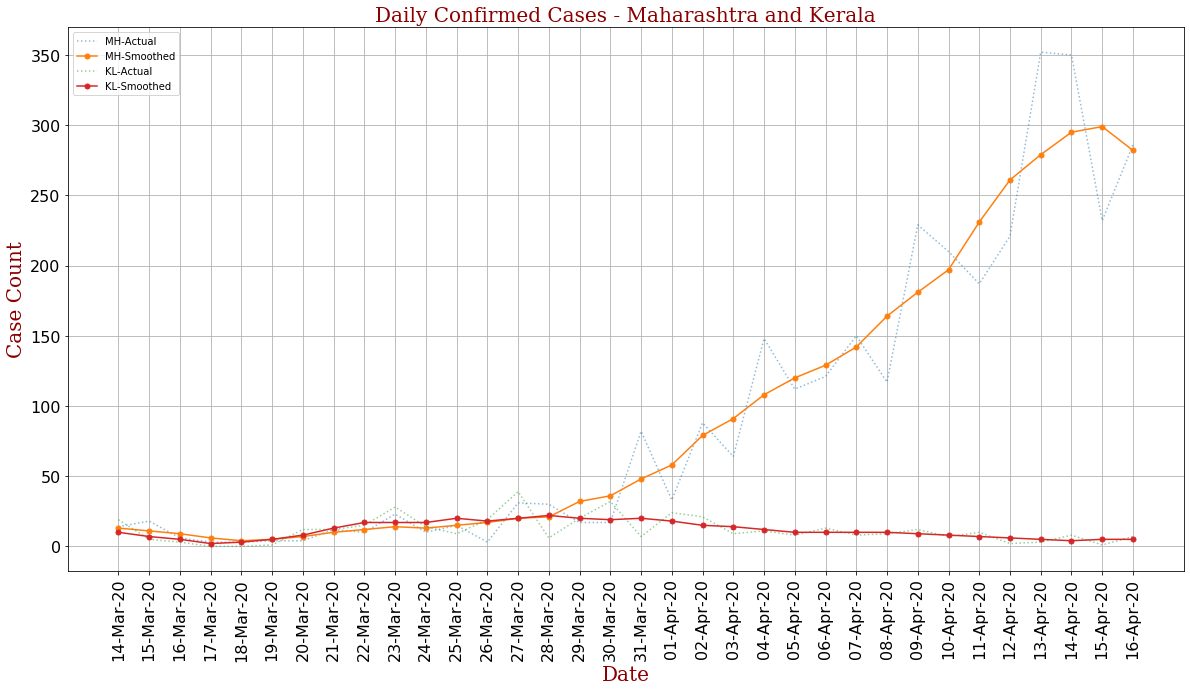

In [215]:
confirmed = data
#print(confirmed.columns)
#print(confirmed.describe())


# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['date'], axis=1)
smoothed = confirmed.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=std_dev).round()
print(smoothed)

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)

plt.title('Daily Confirmed Cases - Maharashtra and Kerala', fontdict=font)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Case Count', fontdict=font)

plt.plot(dates, confirmed['MH'], linestyle=':', alpha=0.5)
plt.plot(dates, smoothed['MH'], marker='.', markersize=10)
plt.plot(dates, confirmed['KL'], linestyle=':', alpha=0.5)
plt.plot(dates, smoothed['KL'], marker='.', markersize=10)

plt.legend(['MH-Actual', 'MH-Smoothed', 'KL-Actual', 'KL-Smoothed'])




Well I lied! I said one state but plotted for two but then anything to do with epidemics, has to have a plot for Kerala :-)

## Function to plot.
Just like any programming, one soon realizes that there are pieces of code that will be repeated a lot, and that would be perfect for writing a function for.

In [236]:
def plot_states(dates, inputdata, index_list, legend_list, title, xlabel, ylabel,legend_loc=2):
    fig=plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    plt.xticks(fontsize=myfontsize)
    plt.yticks(fontsize=myfontsize)
    plt.grid(True)
    plt.title(title, fontdict=font)
    plt.xlabel(xlabel, fontdict=font)
    plt.ylabel(ylabel, fontdict=font)
    
    markers = ['o', 'v', '^', '<', '>', 's', 'p', 'P', '*', 'D']
    marker_count = len(markers)
    count=0
    for index in index_list:
        plt.plot(dates, inputdata[index], marker=markers[count%marker_count], markersize=10)
        count = count+1
    plt.legend(legend_list, loc=legend_loc)


## Cumulative, daily, and smoothed daily plots for the top 10 states with highest total cases.
It is not that useful to plot all states. For easier consumption, it is better to limit it to the top states, i.e., states which has the highest current number of covid positives to date.

In [237]:
confirmed = data
print(confirmed.columns)
#print(confirmed.describe())

# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['date'], axis=1)
smoothed = confirmed.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=2).round()
#ewm = confirmed.ewm(span = 7).mean().round()

cumulative=confirmed.cumsum(axis=0)

# Lets get the 10 states with the highest number of cases
length=len(cumulative.index)
#print(length)
#last_row = cumulative.iloc[-1]
#print(last_row)
#print(cumulative.tail(1))

# sort using column values in the last row
cumulative = cumulative.sort_values(by=length-1, axis=1, ascending=False)
print("Contents of Sorted Dataframe based on a single row index label " + str(length-1))
top_ten = cumulative[cumulative.columns[1:11]]

Index(['date', 'TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DD', 'DL',
       'DN', 'GA', 'GJ', 'HP', 'HR', 'JH', 'JK', 'KA', 'KL', 'LA', 'LD', 'MH',
       'ML', 'MN', 'MP', 'MZ', 'NL', 'OR', 'PB', 'PY', 'RJ', 'SK', 'TG', 'TN',
       'TR', 'UP', 'UT', 'WB', 'Unnamed: 39'],
      dtype='object')
Contents of Sorted Dataframe based on a single row index label 33


## Now lets plot the cumulative, daily, and smoothed daily for the top 10 states

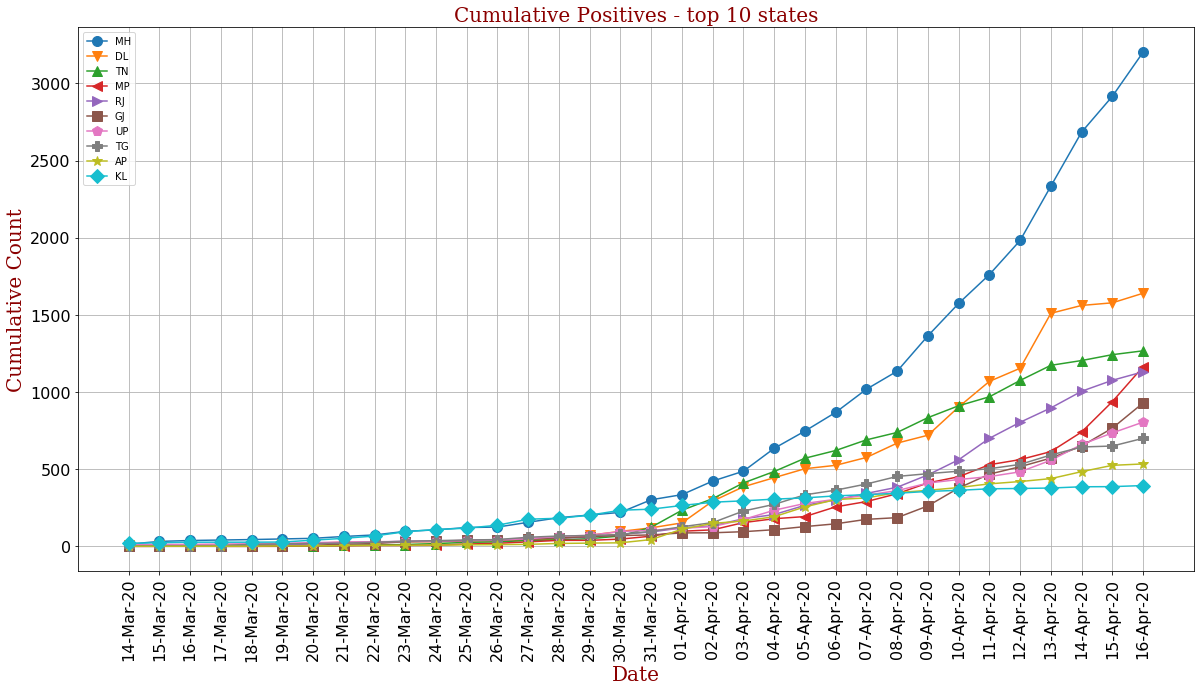

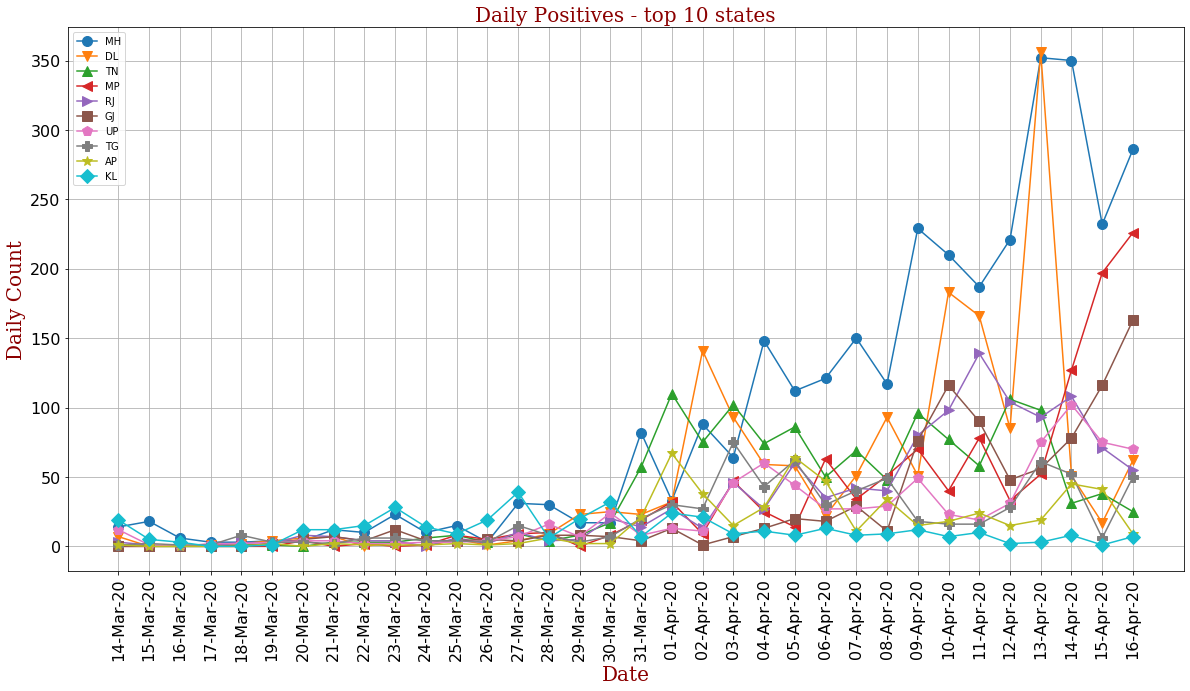

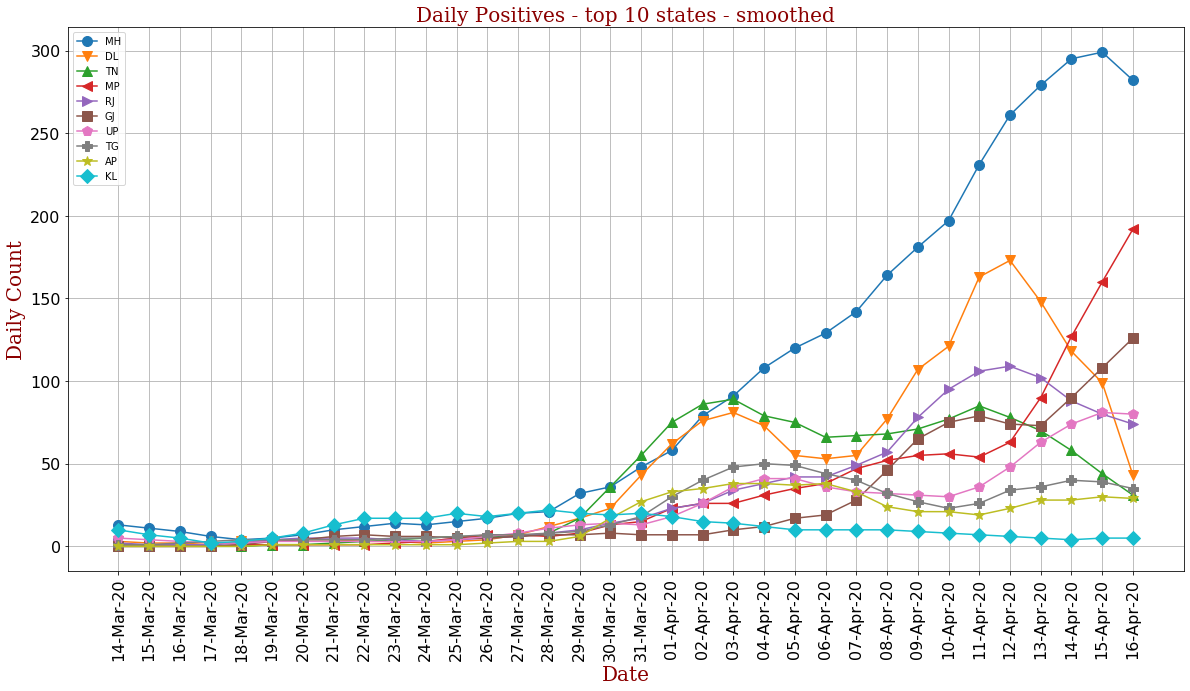

In [238]:
index_list = top_ten.columns
legend_list = index_list
plot_states(dates, cumulative, index_list, legend_list, 'Cumulative Positives - top 10 states', 'Date', 'Cumulative Count')
plot_states(dates, confirmed, index_list, legend_list, 'Daily Positives - top 10 states', 'Date', 'Daily Count')
plot_states(dates, smoothed, index_list, legend_list, 'Daily Positives - top 10 states - smoothed', 'Date', 'Daily Count')
#plot_states(dates, ewm, index_list, legend_list, 'Daily Positives - top 10 states - ewm', 'Date', 'Daily Count')

## Well and good till now but lets try to get some idea of $R_0$ (R-nought)

$R_0$ is a widely accepted measure of how infectious a disease is.
Simply speaking $R_0 = \frac{\text{New cases}}{\text{Existing cases}}$ but the calculation gets complicated. 

Lets start simple. Lets try to calculate the daily $R_0$ as $\frac{\text{new cases today}}{\text{cumulative count till yesterday}}$ and lets see how that looks like. This is probably **incorrect** since it assumes that *all* positive cases in the past has an impact on the daily increase. In reality, once a person is positive, the person is put in hospital and his chances of spreading it to others is very low since hospital takes a lot of precaution. However, we know that even that is not true because we have seen healthcare staff testing positive as well. In short, reality is somewhat more complicated.

     GJ   GJ        GJ
0     0    0       NaN
1     0    0       NaN
2     0    0       NaN
3     0    0       NaN
4     0    0       NaN
5     2    2       inf
6     5    7  2.500000
7     7   14  1.000000
8     4   18  0.285714
9    12   30  0.666667
10    4   34  0.133333
11    4   38  0.117647
12    5   43  0.131579
13    4   47  0.093023
14    8   55  0.170213
15    8   63  0.145455
16    7   70  0.111111
17    4   74  0.057143
18   13   87  0.175676
19    1   88  0.011494
20    7   95  0.079545
21   13  108  0.136842
22   20  128  0.185185
23   18  146  0.140625
24   29  175  0.198630
25   11  186  0.062857
26   76  262  0.408602
27  116  378  0.442748
28   90  468  0.238095
29   48  516  0.102564
30   56  572  0.108527
31   78  650  0.136364
32  116  766  0.178462
33  163  929  0.212794


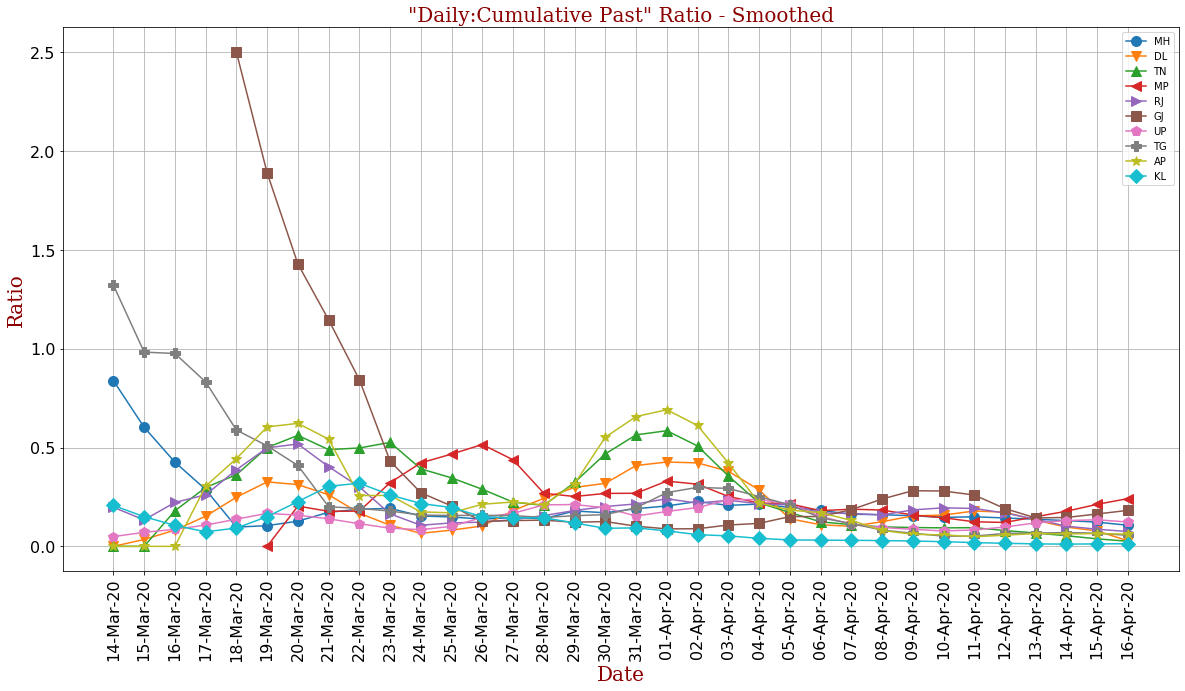

In [248]:
r0_min = confirmed/(cumulative-confirmed)
state='GJ'
print(pd.concat([confirmed[state], cumulative[state],r0_min[state]], axis=1, sort=False))
#plot_states(dates, r0_min, index_list, legend_list, '"Daily:Cumulative Past" Ratio', 'Date', 'Ratio', legend_loc=1)

smoothed_r0_min = r0_min.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=2)
plot_states(dates, smoothed_r0_min, index_list, legend_list, '"Daily:Cumulative Past" Ratio - Smoothed', 'Date', 'Ratio', legend_loc=1)


Clearly, if we assume that *all* positive cases in the past have contributed to the new cases today, this will give the most conservative estimate of $R_0$ since existing cases are way more than daily increase, especially as more and more days go by.

By that logic, the most aggressive estimate of $R_0$ would be to assume that *only* yesterday's cases contributed to today's cases. Lets try to calculate that.

0       NaN
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       2.0
7       5.0
8       7.0
9       4.0
10     12.0
11      4.0
12      4.0
13      5.0
14      4.0
15      8.0
16      8.0
17      7.0
18      4.0
19     13.0
20      1.0
21      7.0
22     13.0
23     20.0
24     18.0
25     29.0
26     11.0
27     76.0
28    116.0
29     90.0
30     48.0
31     56.0
32     78.0
33    116.0
Name: GJ, dtype: float64
     GJ     GJ        GJ
0     0    NaN       NaN
1     0    0.0       NaN
2     0    0.0       NaN
3     0    0.0       NaN
4     0    0.0       NaN
5     2    0.0       inf
6     5    2.0  2.500000
7     7    5.0  1.400000
8     4    7.0  0.571429
9    12    4.0  3.000000
10    4   12.0  0.333333
11    4    4.0  1.000000
12    5    4.0  1.250000
13    4    5.0  0.800000
14    8    4.0  2.000000
15    8    8.0  1.000000
16    7    8.0  0.875000
17    4    7.0  0.571429
18   13    4.0  3.250000
19    1   13.0  0.076923
20    7    1.0  7.000000
21   13    7.0  1

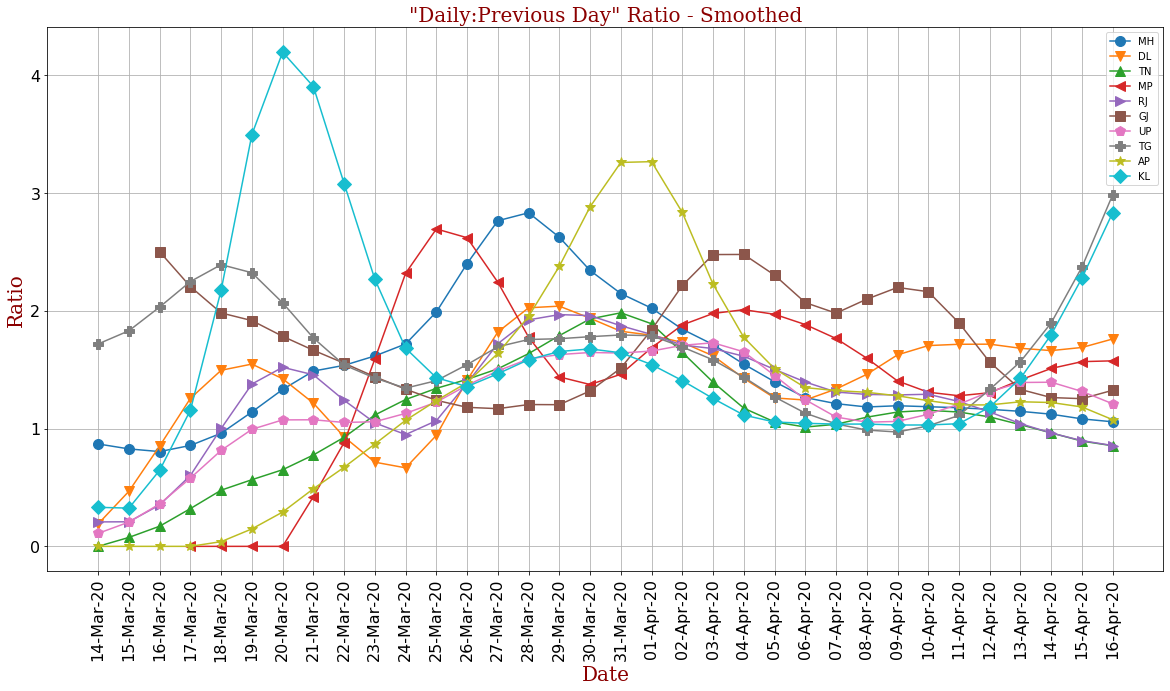

In [260]:
shifted=confirmed.shift(1)
r0_max = confirmed/shifted
state='GJ'
print(pd.concat([confirmed[state], shifted[state],r0_max[state]], axis=1, sort=False))
#plot_states(dates, r0_max, index_list, legend_list, '"Daily:Previous Day" Ratio', 'Date', 'Ratio', legend_loc=1)

smoothed_r0_max = r0_max.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=2)
plot_states(dates, smoothed_r0_max, index_list, legend_list, '"Daily:Previous Day" Ratio - Smoothed', 'Date', 'Ratio', legend_loc=1)


At this point we think we have found the min and the max $R_0$ values. Let's focus on a single state and try to compare the two and maybe see what the mean of that looks like.